# Word Embeddings:
In this notebook we will implement the Skip-Gram model using pytorch and then we will explore this powerfull word representations.

**NOTE:** this notebook requires you to install pytorch. https://anaconda.org/pytorch/pytorch

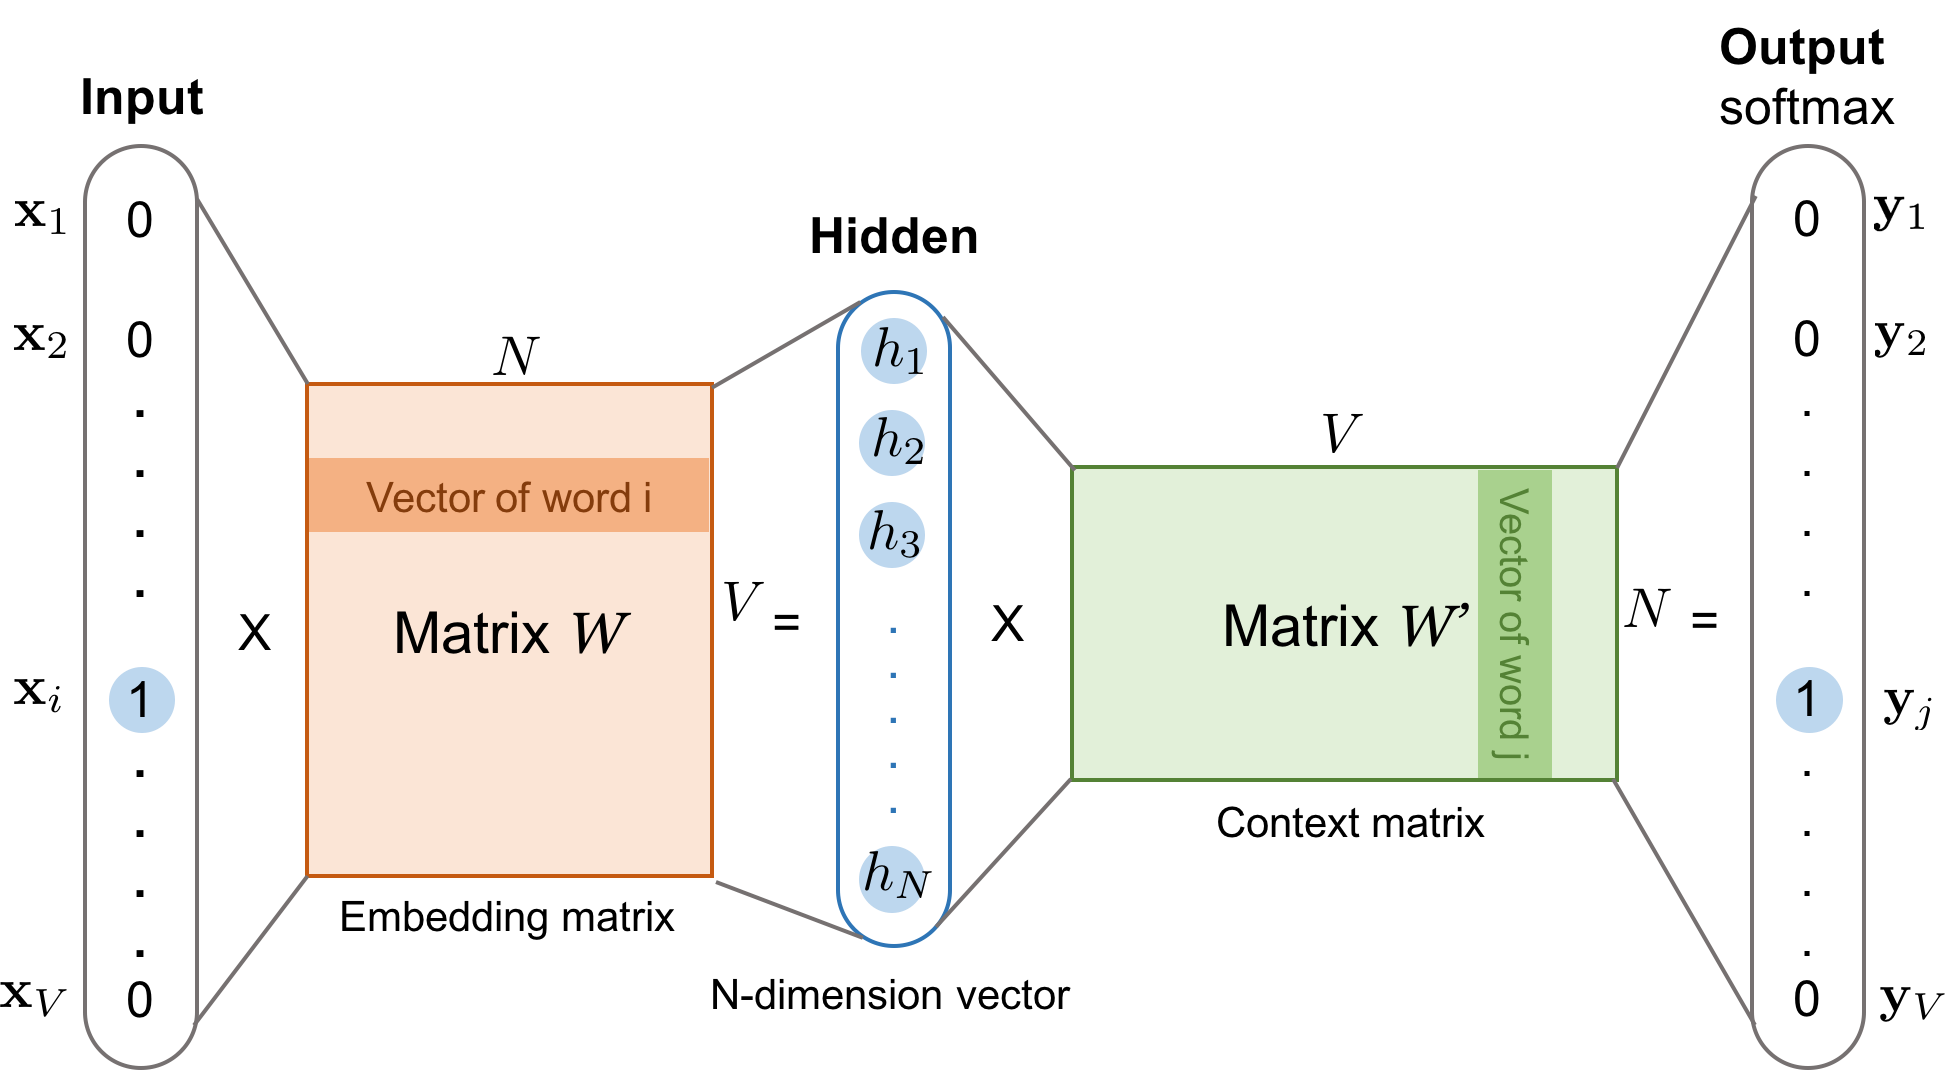

Lets start with a simple corpus:

In [1]:
corpus = [
    'he is a king',
    'she is a queen',
    'she is mad',
    'she is in love',
    'a mountain falls',
    'paris is france capital',   
]

In [2]:
def tokenize_corpus(corpus):
    tokens = [x.split() for x in corpus]
    return tokens

In [3]:
tokenized_corpus = tokenize_corpus(corpus)
vocabulary = {word for doc in tokenized_corpus for word in doc}
word2idx = {w:idx for (idx, w) in enumerate(vocabulary)}

In [4]:
word2idx

{'mad': 0,
 'love': 1,
 'mountain': 2,
 'queen': 3,
 'in': 4,
 'paris': 5,
 'falls': 6,
 'france': 7,
 'capital': 8,
 'is': 9,
 'she': 10,
 'a': 11,
 'he': 12,
 'king': 13}

Has we have seen in the theoretical lesson we want to build pairs of words that appear inside the same context.
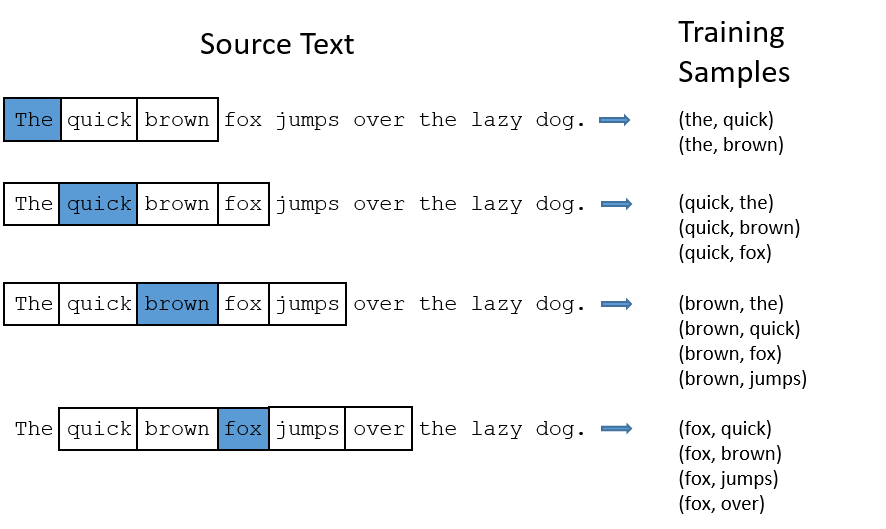

In [5]:
import numpy as np
def build_training(tokenized_corpus, word2idx, window_size=2):
    window_size = 2
    idx_pairs = []
    
    # for each sentence
    for sentence in tokenized_corpus:
        indices = [word2idx[word] for word in sentence]
        # for each word, threated as center word
        for center_word_pos in range(len(indices)):
            # for each window position
            for w in range(-window_size, window_size + 1):
                context_word_pos = center_word_pos + w
                # make soure not jump out sentence
                if  context_word_pos < 0 or \
                    context_word_pos >= len(indices) or \
                    center_word_pos == context_word_pos:
                    continue  
                context_word_idx = indices[context_word_pos]
                idx_pairs.append((indices[center_word_pos], context_word_idx))
    return np.array(idx_pairs)

In [6]:
training_pairs = build_training(tokenized_corpus, word2idx)

In [7]:
training_pairs

array([[12,  9],
       [12, 11],
       [ 9, 12],
       [ 9, 11],
       [ 9, 13],
       [11, 12],
       [11,  9],
       [11, 13],
       [13,  9],
       [13, 11],
       [10,  9],
       [10, 11],
       [ 9, 10],
       [ 9, 11],
       [ 9,  3],
       [11, 10],
       [11,  9],
       [11,  3],
       [ 3,  9],
       [ 3, 11],
       [10,  9],
       [10,  0],
       [ 9, 10],
       [ 9,  0],
       [ 0, 10],
       [ 0,  9],
       [10,  9],
       [10,  4],
       [ 9, 10],
       [ 9,  4],
       [ 9,  1],
       [ 4, 10],
       [ 4,  9],
       [ 4,  1],
       [ 1,  9],
       [ 1,  4],
       [11,  2],
       [11,  6],
       [ 2, 11],
       [ 2,  6],
       [ 6, 11],
       [ 6,  2],
       [ 5,  9],
       [ 5,  7],
       [ 9,  5],
       [ 9,  7],
       [ 9,  8],
       [ 7,  5],
       [ 7,  9],
       [ 7,  8],
       [ 8,  9],
       [ 8,  7]])

In [8]:
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
import torch.nn.functional as F
import torch

def get_onehot_vector(word_idx, vocabulary):
    x = torch.zeros(len(vocabulary)).float()
    x[word_idx] = 1.0
    return x

def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    torch.manual_seed(3)
    W1 = Variable(torch.randn(embedding_dims, len(vocabulary)).float(), requires_grad=True)
    W2 = Variable(torch.randn(len(vocabulary), embedding_dims).float(), requires_grad=True)
    losses = []
    for epo in tqdm(range(epochs)):
        loss_val = 0
        for input_word, target in training_pairs:
            x = Variable(get_onehot_vector(input_word, vocabulary)).float()
            y_true = Variable(torch.from_numpy(np.array([target])).long())

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(W2, z1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true)
            loss_val += loss.item()
            
            # compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, W2, losses

In [9]:
W1, W2, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

In [10]:
import matplotlib.pyplot as plt
def plot_loss(loss):
    x_axis = [epoch+1 for epoch in range(len(loss))]
    plt.plot(x_axis, loss, '-g', linewidth=1, label='Train')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

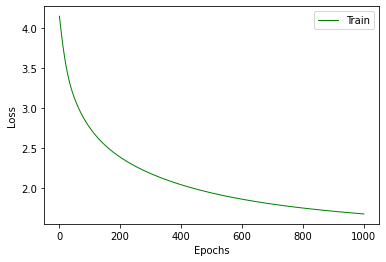

In [11]:
plot_loss(losses)

# Final Embedding Matrix:
From what I have seen the Skip-Gram model can be implemented in 2 different ways:
- With shared parameters, meaning that, W1 and W2 are the same matrix.
- Without shared paramenters accross layers, meaning that, in the end, we have two different matrixes with weights. The final matrix W is the average of both matrixes.

In [12]:
W = W1 + torch.t(W2)
W = (torch.t(W)/2).clone().detach()

In [13]:
W[word2idx["she"]], W[word2idx["mad"]]

(tensor([-0.2743,  0.4537,  0.3416,  0.0463,  0.8479]),
 tensor([-0.3263,  0.2526,  0.6833,  0.2197,  0.6506]))

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["falls"]].numpy()])

array([[2.6660647]], dtype=float32)

In [15]:
euclidean_distances([W[word2idx["she"]].numpy()], [W[word2idx["mad"]].numpy()])

array([[0.47845402]], dtype=float32)

As you can see from the previous example the vector representing "she" and the vector representing "mad" are closer then the vector representing "she" and "falls". This happens because "she" and "falls" never appear together inside the same context window...

### Exercise:
Go back to the Skip-Gram function and change it in order to have only 1 matrix of weights instead of 2. Run the training again and comment the results.

<!---
solution:
class Animal():
    def __init__(self, name, age):
        self.name = name
        self.age = age
        self.energy = 0
    
    def eat(self):
        self.energy += 1
        
    def sleep(self):
        self.energy += 3
    
    def play(self):
        self.energy -= 5

class Dog(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("wauf wauf")

class Cat(Animal):
    def __init__(self, name, age):
        super().__init__(name, age)
    
    def play(self):
        super().play()
        print ("miau miau")        
-->

In [16]:
def Skip_Gram(training_pairs, vocabulary, embedding_dims=5, learning_rate=0.001, epochs=10):
    torch.manual_seed(3)
    W1 = Variable(torch.randn(embedding_dims, len(vocabulary)).float(), requires_grad=True)
    losses = []
    for epo in tqdm(range(epochs)):
        loss_val = 0
        for input_word, target in training_pairs:
            x = Variable(get_onehot_vector(input_word, vocabulary)).float()
            y_true = Variable(torch.from_numpy(np.array([target])).long())

            # Matrix multiplication to obtain the input word embedding
            z1 = torch.matmul(W1, x)
    
            # Matrix multiplication to obtain the z score for each word
            z2 = torch.matmul(torch.transpose(W1, 0, 1), z1)
    
            # Apply Log and softmax functions
            log_softmax = F.log_softmax(z2, dim=0)
            # Compute the negative-log-likelihood loss
            loss = F.nll_loss(log_softmax.view(1,-1), y_true)
            loss_val += loss.item()
            
            # compute the gradient in function of the error
            loss.backward() 
            
            # Update your embeddings
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
        
        losses.append(loss_val/len(training_pairs))
    
    return W1, losses

In [17]:
W1, losses = Skip_Gram(training_pairs, word2idx, epochs=1000)

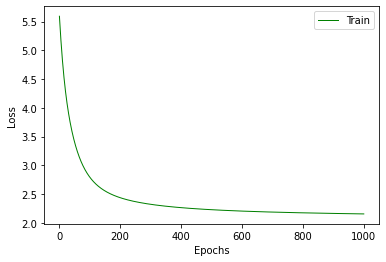

In [18]:
plot_loss(losses)

# Word Embeddings Visualization

Go to https://projector.tensorflow.org/ and visualize Word2Vec embeddings. 

Original Word2Vec repository: https://code.google.com/archive/p/word2vec/

### The End.